In [68]:
# requirements
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

# Dataset IV

In [69]:
# dataset 4
n = 200
x = 3 * (np.random.rand(n, 4) - 0.5)
y = (2 * x[:, 0] - 1 * x[:, 1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y = 2 * y - 1
y.shape

(200,)

In [70]:
lams = np.arange(0.01, 10, 0.01)


In [71]:
def hinge_loss(x, y, w):
    return np.sum(np.maximum(np.zeros_like(y), -y * (x @ w)))

def l1_reg(w, lam):
    ret = lam * (np.sum(np.abs(w)))
    print(ret)
    return ret


# Using CVXOPT

In [72]:
w = cv.Variable((4))
loss = cv.sum(cv.pos(1 - cv.multiply(y, x @ w)))
reg = cv.norm(w, 1)
lam = cv.Parameter(nonneg=True)
prob = cv.Problem(cv.Minimize(loss + lam * reg))

In [73]:
w_hist_cvxopt = []
beta_vals = []
for i, lam_value in enumerate(lams):
    lam.value = lam_value
    prob.solve()
    w_hist_cvxopt.append(w.value)


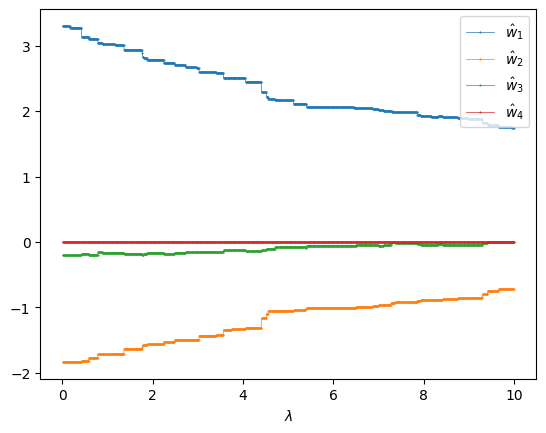

In [74]:
plt.plot(lams, w_hist_cvxopt, 'o-', linewidth=0.5, markersize=0.5, label=['$\hat{w}_1$', '$\hat{w}_2$', '$\hat{w}_3$', '$\hat{w}_4$'])
plt.legend()
plt.xlabel('$\lambda$')
plt.show()

# (Batch) Proximal Subgradient Method

In [75]:
# proximal gradient
def st_ops(mu, q):
  x_proj = np.zeros(mu.shape)
  for i in range(len(mu)):
    if mu[i] > q:
      x_proj[i] = mu[i] - q
    else:
      if np.abs(mu[i]) < q:
        x_proj[i] = 0
      else:
        x_proj[i] = mu[i] + q; 
  return x_proj

In [76]:
def subgrad(x, y, w):
    ret = np.zeros([w.shape[0], 1])
    for i in range(n):
        xx = x[i].reshape(-1, 1)
        # print('xx.shape: ', xx.shape)
        # print('x[i].shape: ', x[i].shape)
        # print('y[i].shape: ', y[i].shape)
        

        if y[i] * (w.T @ xx) < 1:
            ret += -y[i] * xx
    return ret.reshape(-1)

In [147]:
# loss_hist_batch_steepest_gradient = []
w_init = np.zeros_like(x[0])
# gamma = np.max(np.linalg.eigvals(2 * x.T @ x))
gamma = np.max(np.linalg.eigvals(x.T @ x))
# gamma = np.max(x) 
# gamma = 0.5 * (np.linalg.norm(x, ord='fro'))

eta = 1 / gamma

In [148]:
gamma

166.68986961443304

In [135]:
num_iter = 200

In [136]:
loss_history_pg = []
min_fvalue_hist_pg = []
w_hist_pg = []
w_hist_at_lam = []

min_fvalue = np.inf
min_lam_idx = lams[0]

for i, lam in enumerate(lams):
  w_hat_lam = []
  fvalues = []
  wt = w_init

  for t in range(num_iter):
    res = 1 - y * (x @ wt)

    grad = subgrad(x, y, wt)
    # print('grad.shape', grad.shape)
    wt = st_ops(wt - eta * grad, lam / gamma)
    reg = lam * np.sum(np.abs(wt))
    fv = np.sum(np.maximum(res, 0)) + reg
    # print('fv.shape', fv.shape)
    fvalues.append(fv)
    w_hat_lam.append(wt)

  min_fvalue_hist_pg.append(min(fvalues))
  w_hist_pg.append(wt)
  if min(fvalues) < min_fvalue:
    min_fvalue = min(fvalues)
    loss_history_pg = fvalues[:]
    w_hist_at_lam = w_hat_lam[:]
    min_lam_idx = i


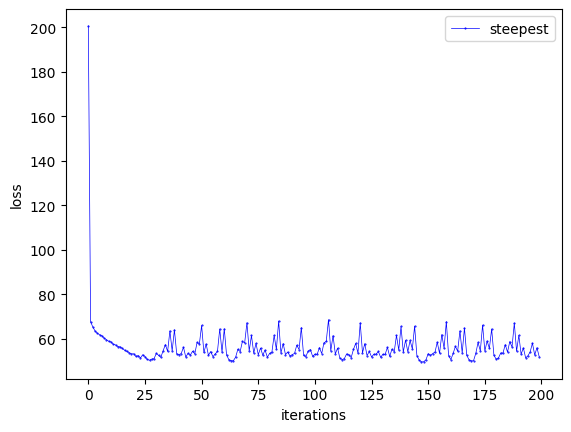

In [137]:
plt.plot(loss_history_pg, 'bo-', linewidth=0.5, markersize=0.5, label='steepest')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

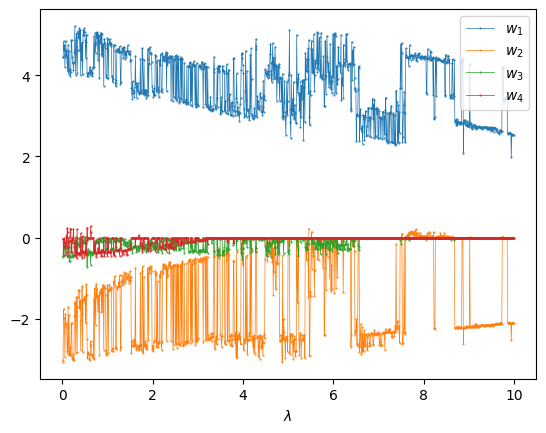

In [138]:
plt.plot(lams, w_hist_pg, 'o-', linewidth=0.5, markersize=0.5, label=['$w_1$', '$w_2$', '$w_3$', '$w_4$'])
plt.legend()
plt.xlabel('$\lambda$')
# plt.ylabel('w')
plt.show()

In [139]:
w_hist_cvxopt[0]

array([ 3.30086921e+00, -1.83249103e+00, -2.06144438e-01,  6.74020843e-04])

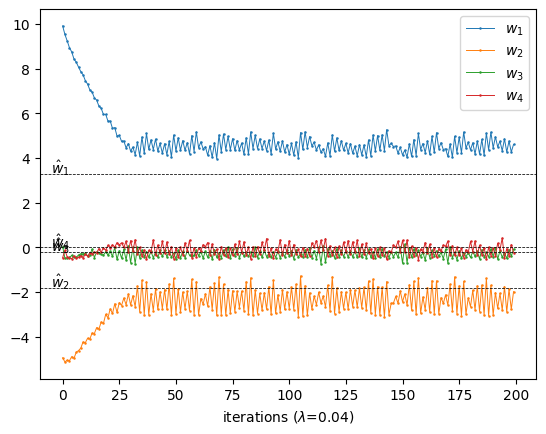

In [140]:
w_hat_labels = ['$\hat{w}_1$', '$\hat{w}_2$', '$\hat{w}_3$', '$\hat{w}_4$']
label_colors = ['blue', 'yellow', 'green', 'red']

plt.plot(w_hist_at_lam, 'o-', linewidth=0.7, markersize=0.8, label=['$w_1$', '$w_2$', '$w_3$', '$w_4$'])

[plt.axhline(y=w, linewidth=0.55, linestyle='--', color='black') for w in w_hist_cvxopt[min_lam_idx]]
[plt.annotate(xy=(-5, w + 0.05), text=label) for w, label in zip(w_hist_cvxopt[min_lam_idx], w_hat_labels)]
# plt.axhline(w_hist_cvxopt[min_lam_idx], linewidth=0.5, label=[['$\hat{w}_1$', '$\hat{w}_2$', '$\hat{w}_3$', '$\hat{w}_4$']])
plt.legend()
plt.xlabel(f'iterations ($\lambda$={lams[min_lam_idx]})')
# plt.ylabel('w')
plt.show()

In [141]:
w_hist_cvxopt[min_lam_idx]

array([ 3.30086921e+00, -1.83249103e+00, -2.06144438e-01,  6.74020854e-04])

In [142]:
w_hist_pg[min_lam_idx]

array([ 4.60982092, -1.98494744, -0.08190545, -0.2322356 ])